<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Probabilities-and-weights-dependency-on-training-protocol" data-toc-modified-id="Probabilities-and-weights-dependency-on-training-protocol-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Probabilities and weights dependency on training protocol</a></span><ul class="toc-item"><li><span><a href="#Off-line-learning" data-toc-modified-id="Off-line-learning-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Off-line learning</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#A-simple-example" data-toc-modified-id="A-simple-example-1.1.0.1"><span class="toc-item-num">1.1.0.1&nbsp;&nbsp;</span>A simple example</a></span></li></ul></li></ul></li><li><span><a href="#Systematic-analysis" data-toc-modified-id="Systematic-analysis-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Systematic analysis</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Variability-with-training-times" data-toc-modified-id="Variability-with-training-times-1.2.0.1"><span class="toc-item-num">1.2.0.1&nbsp;&nbsp;</span>Variability with training times</a></span></li><li><span><a href="#Training-times-variability-in-just-one-unit" data-toc-modified-id="Training-times-variability-in-just-one-unit-1.2.0.2"><span class="toc-item-num">1.2.0.2&nbsp;&nbsp;</span>Training times variability in just one unit</a></span></li><li><span><a href="#Tau_z" data-toc-modified-id="Tau_z-1.2.0.3"><span class="toc-item-num">1.2.0.3&nbsp;&nbsp;</span>Tau_z</a></span></li><li><span><a href="#Inter-pulse-interval" data-toc-modified-id="Inter-pulse-interval-1.2.0.4"><span class="toc-item-num">1.2.0.4&nbsp;&nbsp;</span>Inter-pulse-interval</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Probabilities and weights dependency on training protocol
Will calculated the weights and probabilities for both on-line and off-line learning and dependend on both training time and $\tau_z$

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, Network
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities
from plotting_functions import plot_weight_matrix, plot_network_activity_angle
from analysis_functions import calculate_probability_theo, calculate_joint_probabilities_theo
from analysis_functions import calculate_self_probability_theo, calculate_get_weights_theo


epsilon = 10e-80
vmin = -3.0

## Off-line learning

#### A simple example

In [2]:
strict_maximum = True

g_a = 1.0
g_I = 10.0
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.025

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Training protocol
training_times = 0.100
training_times = [training_times for i in range(n_patterns)]
inter_pulse_intervals = [0 for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1

# Manager properties
dt = 0.0001
values_to_save = ['o']

from_index = 2
to_index = 3

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                        minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)

T1 = training_times[from_index]
T2 = training_times[to_index] 
IPI = inter_pulse_intervals
Ts = T1 + IPI
T_start = sum(training_times[:from_index])
Ttotal = manager.T_training_total

p_pre_theo = calculate_probability_theo(T1, T_start, Ttotal, tau_z_pre)
p_pre_sim = nn.p_pre[from_index]
print(r'p_{pre}')
print(f"theo = {p_pre_theo:5.5f}, sim = {p_pre_sim:5.5f}")

p_post_theo = calculate_probability_theo(T2, T_start, Ttotal, tau_z_post)
p_post_sim = nn.p_post[to_index]
print(r'p_{post}')
print(f"theo = {p_post_theo:5.5f}, sim = {p_post_sim:5.5f}")


p_co_theo = calculate_joint_probabilities_theo(T1, Ts, T2, Ttotal, tau_z_pre, tau_z_post)
p_co_sim = nn.P[to_index, from_index]
print(r'p_{co}')
print(f"theo = {p_co_theo:5.5f}, sim = {p_co_sim:5.5f}")

aux = calculate_get_weights_theo(T1, T2, Ttotal, tau_z_pre, tau_z_post, Tr=T2, IPI=IPI)
w_self_theo, w_next_theo, w_rest_theo, w_back_theo = aux
print('weights theo')
print(f"w_self = {w_self_theo:5.5f}, w_next = {w_next_theo:5.5f}, w_rest = {w_rest_theo:5.5f}, w_back = {w_back_theo:5.5f}")
w_self_sim = nn.w[from_index, from_index] 
w_next_sim = nn.w[to_index, from_index]
w_rest_sim = nn.w[to_index + 1, from_index]
w_back_sim = nn.w[from_index - 1, from_index]
print('weights sim')
print(f"w_self = {w_self_sim:5.5f}, w_next = {w_next_sim:5.5f}, w_rest = {w_rest_sim:5.5f}, w_back = {w_back_sim:5.5f}")

p_post_from_theo = calculate_probability_theo(T1, T_start, Ttotal, tau_z_post)
p_post_to_theo = calculate_probability_theo(T2, T_start, Ttotal, tau_z_post)
w_diff_theo = w_self_theo - w_next_theo
beta_diff_theo = np.log10(p_post_from_theo) - np.log10(p_post_to_theo)
B_theo = (w_diff_theo + beta_diff_theo) / g_a

w_diff_sim = w_self_sim - w_next_sim
beta_diff_sim = manager.nn.beta[from_index] - manager.nn.beta[to_index]
B_sim = (w_diff_sim + beta_diff_sim) / g_a

print(f"w_diff_sim = {w_diff_sim:5.5f}, w_diff_theo = {w_diff_theo:5.5f}")
print(f"beta_diff_sim = {beta_diff_sim:5.5f}, beta_diff_theo = {beta_diff_theo:5.5f}")

if False:
    T_next_theo = calculate_persistence_time(tau_a, w_diff, beta_diff, g_a, tau_s, perfect=False)
    T_recall = T_next_theo * n_patterns + tau_s
    T_cue = tau_s
    nr = representation.network_representation
    aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=0.009, reset=True, empty_history=True)
    success, pattern_sequence, persistent_times, timings = aux
    T_next_sim = persistent_times[from_index]

    print(f"T_sim = {T_next_sim:5.5f}, T_theo = {T_next_theo:5.5f}")

p_{pre}
theo = 0.06667, sim = 0.06667
p_{post}
theo = 0.06667, sim = 0.06667
p_{co}
theo = 0.00181, sim = 0.00180
weights theo
w_self = 1.07215, w_next = -0.38980, w_rest = -2.99556, w_back = -5.24603
weights sim
w_self = 1.07225, w_next = -0.39173, w_rest = -3.00272, w_back = -5.29740
w_diff_sim = 1.46398, w_diff_theo = 1.46194
beta_diff_sim = 0.00000, beta_diff_theo = 0.00000


## Systematic analysis

In [3]:
def update_saving_dictionary(values_dictionary, update_index, from_index, to_index,
                             training_times, manager, IPI=None):
    tau_z_pre = manager.nn.tau_z_pre
    tau_z_post = manager.nn.tau_z_post
    g_a = manager.nn.g_a

    T1 = training_times[from_index]
    T2 = training_times[to_index]
    if IPI is None:
        IPI = 0
    Ts = T1 + IPI
    T_start = sum(training_times[:from_index])
    Ttotal = manager.T_training_total
    
    # Get the pre-synaptic probabilities
    p_pre_theo = calculate_probability_theo(T1, T_start, Ttotal, tau_z_pre)
    p_post_theo = calculate_probability_theo(T2, T_start, Ttotal, tau_z_post)
    # Get the post-synaptic probabilities
    p_pre_sim = manager.nn.p_pre[from_index]
    p_post_sim = manager.nn.p_post[to_index]

    # Get the joint-probabilities
    p_co_theo = calculate_joint_probabilities_theo(T1, Ts, T2, Ttotal, tau_z_pre, tau_z_post)
    p_co_sim = nn.P[to_index, from_index]

    # Calculate the theoretical weights
    aux = calculate_get_weights_theo(T1, T2, Ttotal, tau_z_pre, tau_z_post, Tr=T2, IPI=IPI)
    w_self_theo, w_next_theo, w_rest_theo, w_back_theo = aux

    # Calculate the simulation weights
    w_self_sim = manager.nn.w[from_index, from_index]
    w_next_sim = manager.nn.w[to_index, from_index]
    w_rest_sim = manager.nn.w[to_index + 1, from_index]
    w_back_sim = manager.nn.w[from_index - 1, from_index]

    # Calculate the inertia parameters B
    p_post_from_theo = calculate_probability_theo(T1, T_start, Ttotal, tau_z_post)
    p_post_to_theo = calculate_probability_theo(T2, T_start, Ttotal, tau_z_post)
    w_diff_theo = w_self_theo - w_next_theo
    beta_diff_theo = np.log10(p_post_from_theo) - np.log10(p_post_to_theo)
    B_theo = (w_diff_theo + beta_diff_theo) / g_a

    w_diff_sim = w_self_sim - w_next_sim
    beta_diff_sim = manager.nn.beta[from_index] - manager.nn.beta[to_index]
    B_sim = (w_diff_sim + beta_diff_sim) / g_a

    # Update the dictionary
    for value in values_dictionary.keys():
        aux = locals()[value]
        values_dictionary[value][update_index] = aux

    manager.T_training_total = 0.0


values_to_save_string = ['p_pre_theo', 'p_pre_sim', 'p_post_theo', 'p_post_sim', 'p_co_theo', 'p_co_sim',
                         'w_self_theo', 'w_self_sim', 'w_next_theo', 'w_next_sim', 'w_rest_theo', 'w_rest_sim',
                         'w_back_theo', 'w_back_sim', 'B_theo', 'B_sim', 'w_diff_theo', 'w_diff_sim',
                         'beta_diff_theo', 'beta_diff_sim']

def plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None):
    linewidth = 8
    markersize = 28
    colors = sns.color_palette()
    independent_variable = values_dictionary['independent values']
    
    if ax is None:
        figsize = (16, 6)
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        
    xlabel = values_dictionary['independent']
    for index, what_to_plot in enumerate(what_to_plot_set):
        what_to_plot_theo = what_to_plot + '_theo'
        what_to_plot_sim = what_to_plot +  '_sim'
        dependent_variable_theo = values_dictionary[what_to_plot_theo]
        dependent_variable_sim = values_dictionary[what_to_plot_sim]
        
    
        ax.plot(independent_variable, dependent_variable_sim, '*', ms=markersize, 
                color=colors[index], label=what_to_plot_sim)
        ax.plot(independent_variable, dependent_variable_theo, '-', lw=linewidth,
                color=colors[index], label=what_to_plot_theo)

    ax.set_xlabel(xlabel)
    ax.axhline(0, ls='--', color='gray')
    ax.axvline(0, ls='--', color='gray')
    ax.legend()
    
    return ax

#### Variability with training times

In [4]:
strict_maximum = True

g_a = 1.0
g_I = 10.0
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.025

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Training protocol
training_times = 0.100
training_times = [training_times for i in range(n_patterns)]
inter_pulse_intervals = 0.0
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1

# Manager properties
dt = 0.0001
values_to_save = ['o']

from_index = 2
to_index = 3

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                        minicolumns=minicolumns)


In [5]:
%%time
num = 30

training_times_vector = np.linspace(0.020, 3.0, num=num)
values_dictionary_training_times_equal = {name:np.zeros(num) for name in values_to_save_string}

for index, training_times in enumerate(training_times_vector):
    training_times = [training_times for i in range(n_patterns)]

    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)
    
    # Update values
    update_saving_dictionary(values_dictionary_training_times_equal, index, from_index, to_index,
                             training_times, manager)
    
values_dictionary_training_times_equal['independent'] = 'training times'
values_dictionary_training_times_equal['independent values'] = training_times_vector

CPU times: user 1min 56s, sys: 9.12 s, total: 2min 5s
Wall time: 1min 38s


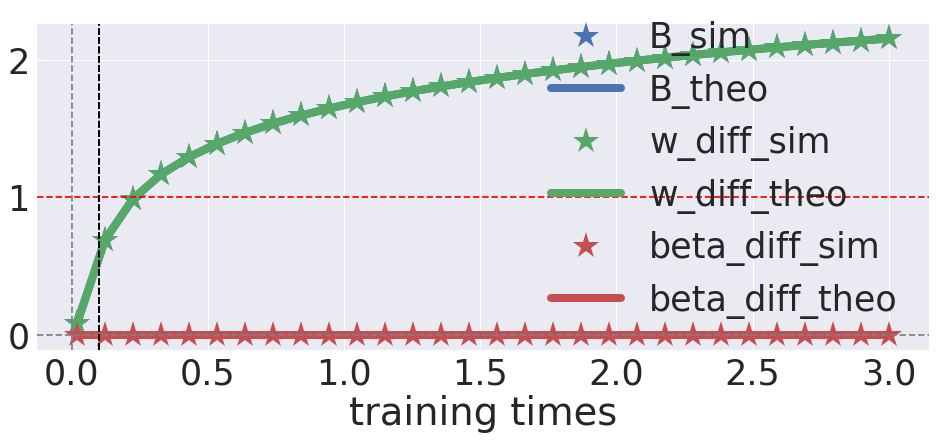

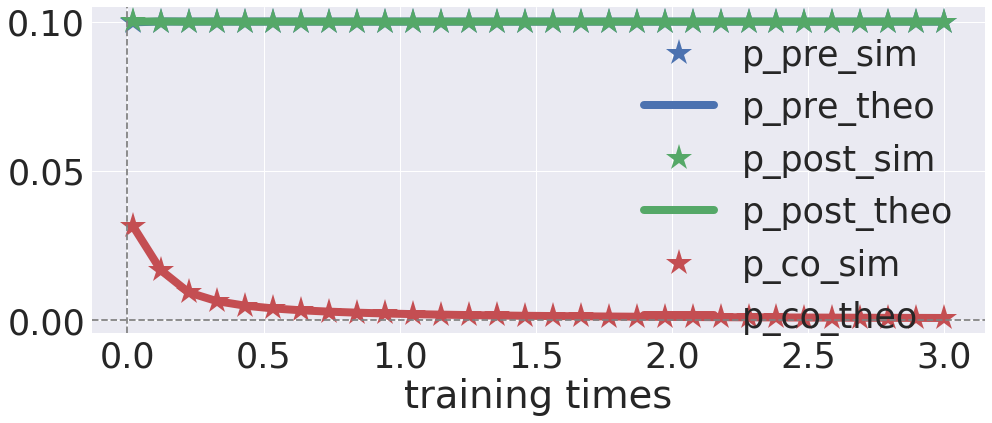

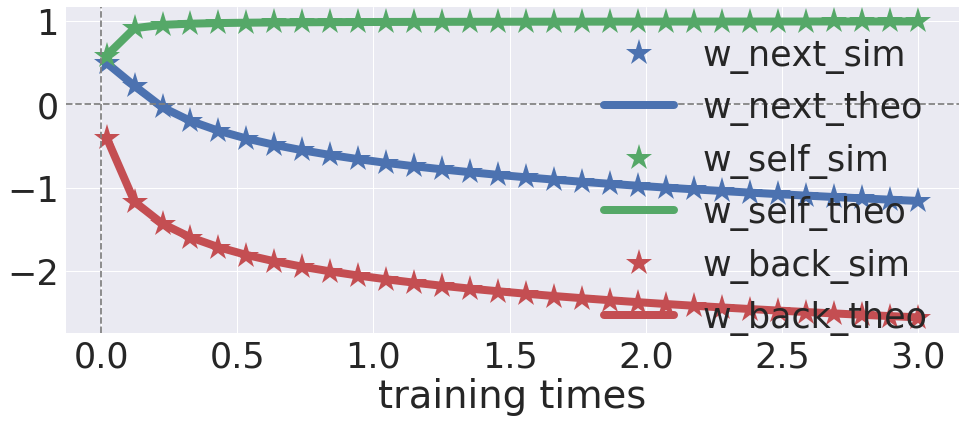

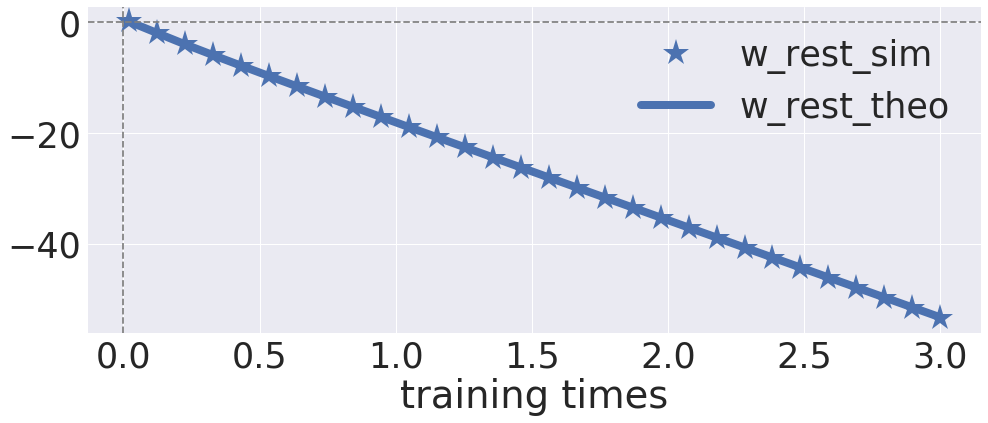

In [6]:
values_dictionary = values_dictionary_training_times_equal
what_to_plot_set = ['B', 'w_diff', 'beta_diff']
ax = plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
ax.axhline(g_a, ls='--', color='red')
ax.axvline(0.100, ls='--', color='black')
what_to_plot_set = ['p_pre', 'p_post', 'p_co']
plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
ax.axvline(0.100, ls='--', color='black')
what_to_plot_set = ['w_next', 'w_self', 'w_back']
plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
ax.axvline(0.100, ls='--', color='black')
what_to_plot_set = ['w_rest']
plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
ax.axvline(0.100, ls='--', color='black');

#### Training times variability in just one unit

In [7]:
strict_maximum = True

g_a = 1.0
g_I = 10.0
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Training protocol
training_times = 0.100
training_times = [training_times for i in range(n_patterns)]
inter_pulse_intervals = 0.0
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1

# Manager properties
dt = 0.0001
values_to_save = ['o']

from_index = 2
to_index = 3

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                        minicolumns=minicolumns)


In [8]:
%%time
num = 30

training_times_vector = np.linspace(0.020, 3.0, num=num)
values_dictionary_training_times_diff = {name:np.zeros(num) for name in values_to_save_string}

for index, training_diff in enumerate(training_times_vector):
    training_times[from_index] = training_diff
    
    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)

    # Update the dictionary
    update_saving_dictionary(values_dictionary_training_times_diff, index, from_index, to_index,
                             training_times, manager)
    
values_dictionary_training_times_diff['independent'] = 'training times of unit'
values_dictionary_training_times_diff['independent values'] = training_times_vector

CPU times: user 19.1 s, sys: 168 ms, total: 19.3 s
Wall time: 13.4 s


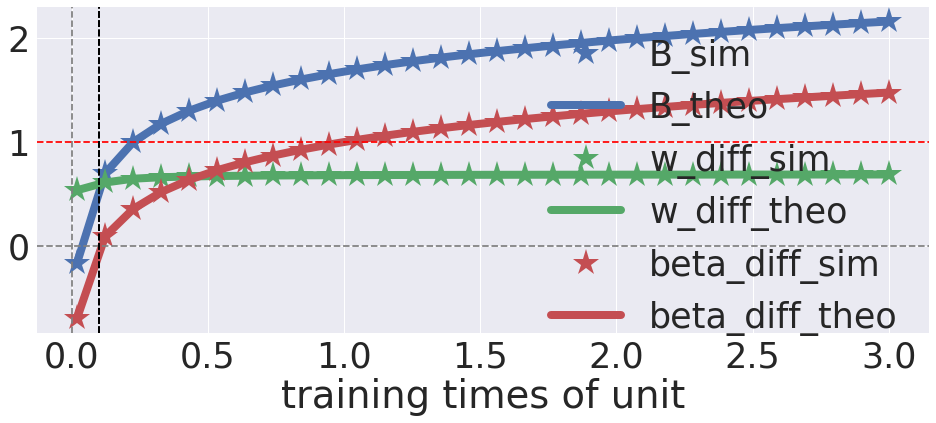

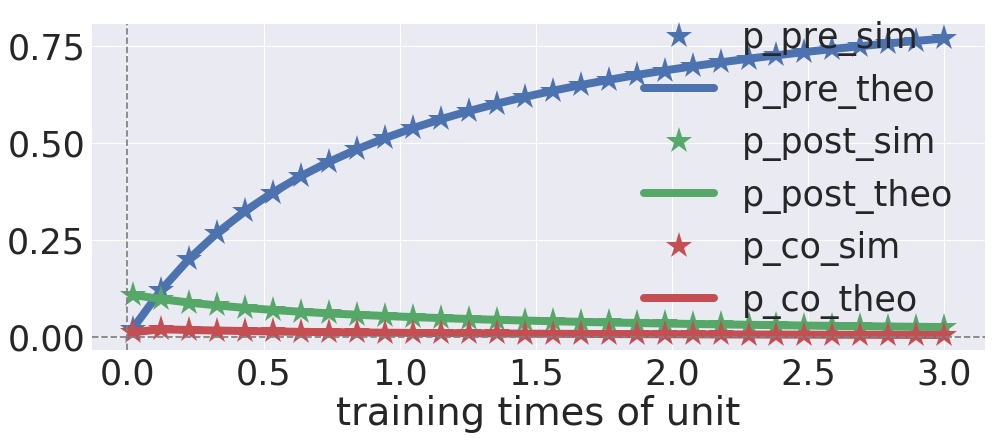

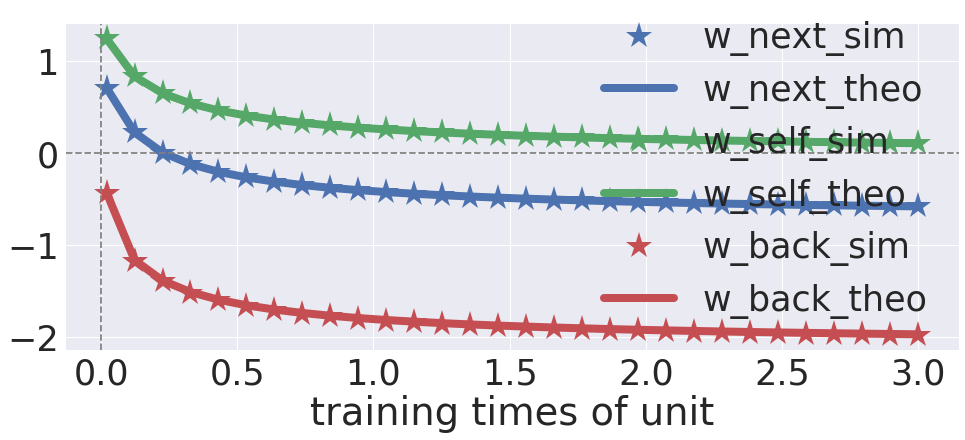

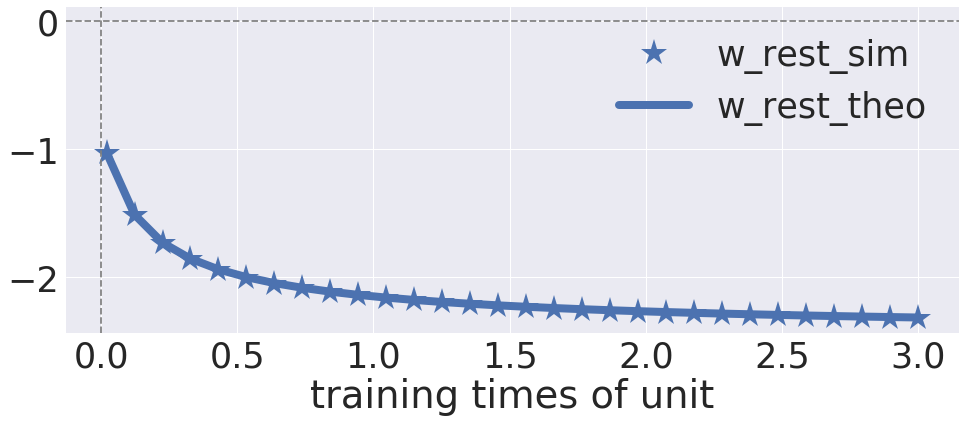

In [9]:
values_dictionary = values_dictionary_training_times_diff
what_to_plot_set = ['B', 'w_diff', 'beta_diff']
ax = plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
ax.axhline(g_a, ls='--', color='red')
ax.axvline(0.100, ls='--', color='black')
what_to_plot_set = ['p_pre', 'p_post', 'p_co']
plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
ax.axvline(0.100, ls='--', color='black')
what_to_plot_set = ['w_next', 'w_self', 'w_back']
plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
ax.axvline(0.100, ls='--', color='black')
what_to_plot_set = ['w_rest']
plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
ax.axvline(0.100, ls='--', color='black');

#### Tau_z

In [10]:
strict_maximum = True

g_a = 1.0
g_I = 10.0
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Training protocol
training_times = 0.100
training_times = [training_times for i in range(n_patterns)]
inter_pulse_intervals = 0.0
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1

# Manager properties
dt = 0.0001
values_to_save = ['o']

from_index = 2
to_index = 3

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                        minicolumns=minicolumns)

In [11]:
%%time
num = 30

tau_z_vector = np.linspace(0.005, 0.150, num=num)
values_dictionary_tau_z = {name:np.zeros(num) for name in values_to_save_string}

for index, tau_z_pre in enumerate(tau_z_vector):
    setattr(nn, 'tau_z_pre', tau_z_pre)
    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)
    T1 = training_times[from_index]
    T2 = training_times[to_index]
    Ts = T1
    T_start = sum(training_times[:from_index])
    update_saving_dictionary(values_dictionary_tau_z, index, from_index, to_index,
                             training_times, manager)
    
values_dictionary_tau_z['independent'] = r'$\tau_{z_{pre}}$'
values_dictionary_tau_z['independent values'] = tau_z_vector 

CPU times: user 12.7 s, sys: 236 ms, total: 12.9 s
Wall time: 7.12 s


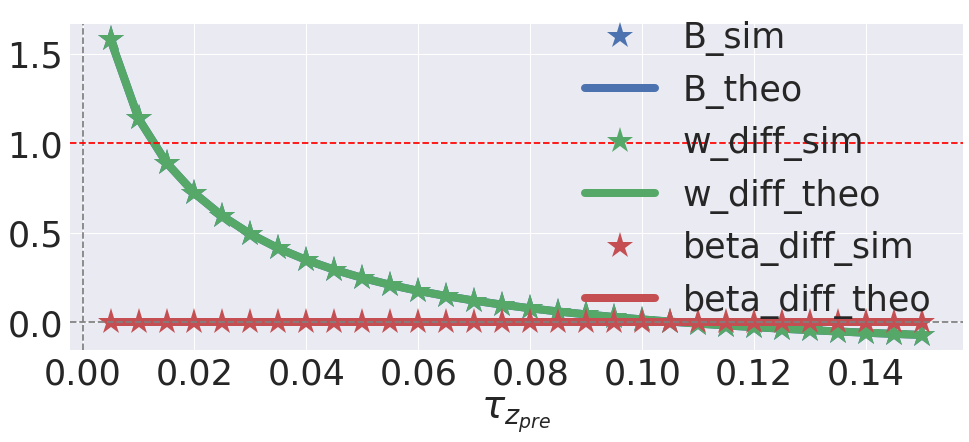

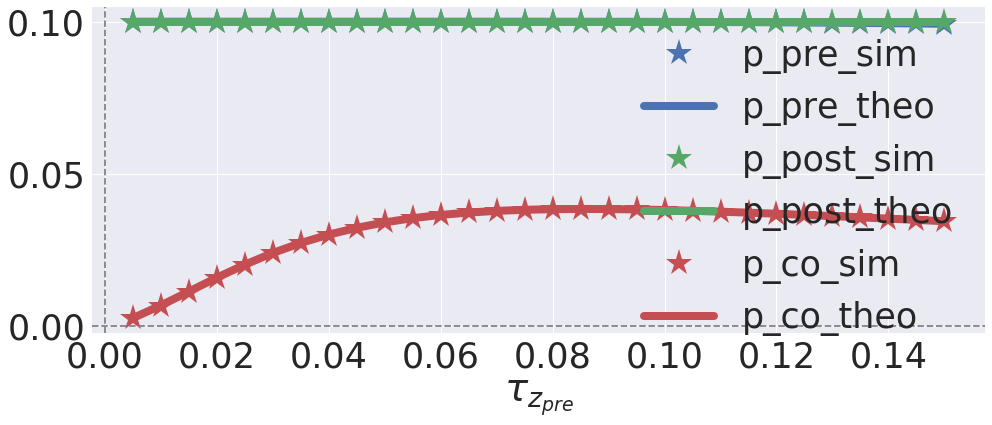

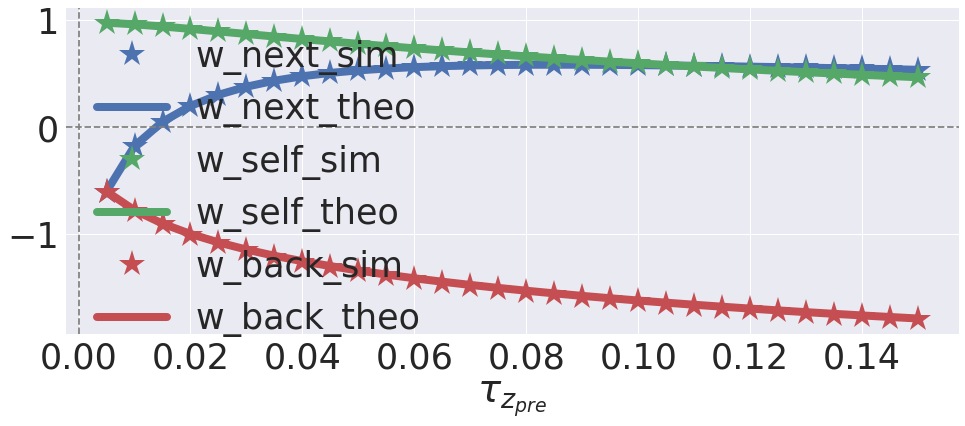

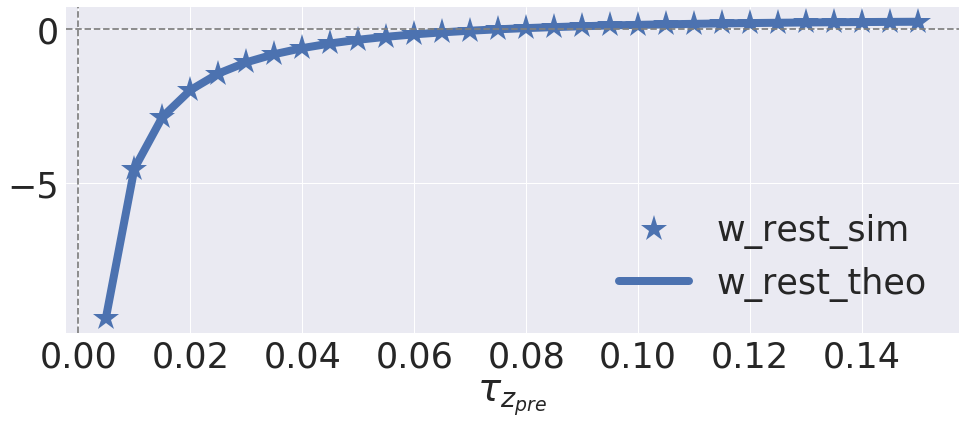

In [12]:
values_dictionary = values_dictionary_tau_z
what_to_plot_set = ['B', 'w_diff', 'beta_diff']
ax = plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
ax.axhline(g_a, ls='--', color='red')
what_to_plot_set = ['p_pre', 'p_post', 'p_co']
plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
what_to_plot_set = ['w_next', 'w_self', 'w_back']
plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
what_to_plot_set = ['w_rest']
plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None);

#### Inter-pulse-interval

In [13]:
strict_maximum = True

g_a = 1.0
g_I = 10.0
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Training protocol
training_times = 0.100
training_times = [training_times for i in range(n_patterns)]
inter_pulse_intervals = 0.0
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1

# Manager properties
dt = 0.0001
values_to_save = ['o']

from_index = 2
to_index = 3

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                        minicolumns=minicolumns)

In [14]:
%%time
num = 30

IPI_vector = np.linspace(0.0, 0.100, num=num)
values_dictionary_IPI = {name:np.zeros(num) for name in values_to_save_string}

for index, IPI in enumerate(IPI_vector):
    inter_pulse_intervals = IPI
    
    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)

    # Update the dictionary
    update_saving_dictionary(values_dictionary_IPI, index, from_index, to_index,
                             training_times, manager, IPI=IPI)
    
    
values_dictionary_IPI['independent'] = 'IPI'
values_dictionary_IPI['independent values'] = IPI_vector

CPU times: user 15.6 s, sys: 140 ms, total: 15.8 s
Wall time: 9.94 s


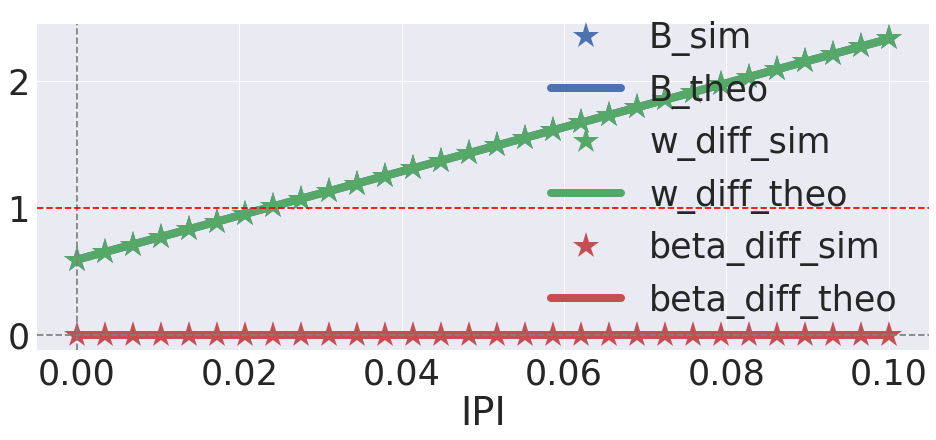

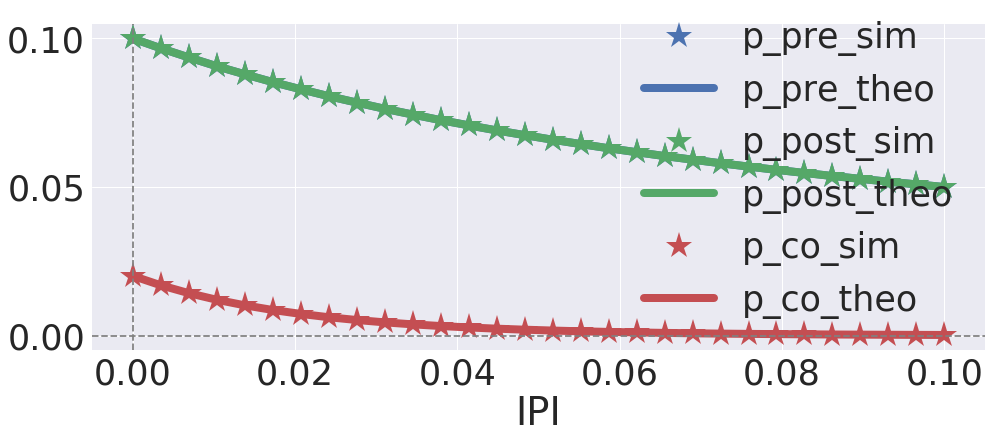

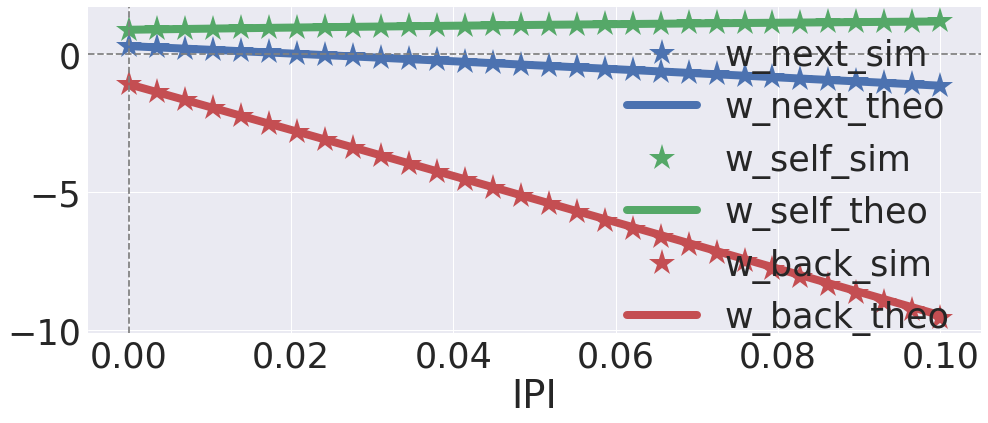

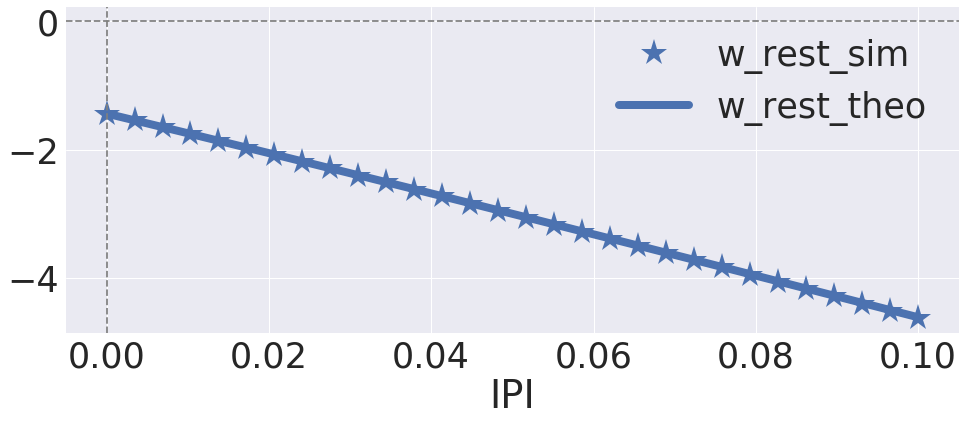

In [15]:
values_dictionary = values_dictionary_IPI
what_to_plot_set = ['B', 'w_diff', 'beta_diff']
ax = plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
ax.axhline(g_a, ls='--', color='red')
what_to_plot_set = ['p_pre', 'p_post', 'p_co']
plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
what_to_plot_set = ['w_next', 'w_self', 'w_back']
plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
what_to_plot_set = ['w_rest']
plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None);